In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob

In [2]:
climate_path = "/Users/dgagne/gd/Lorenz GAN docs/exp_u_chey/gan_climate/02000000/"
#climate_path = "../exp_climate_gan/"
climate_files = sorted(glob(climate_path + "*.nc"))
climate_gan_x = []
for climate_file in climate_files:
    climate_obj = xr.open_dataset(climate_file)
    climate_gan_x.append(climate_obj["x"].values)
    climate_obj.close()
    del climate_obj

In [4]:
climate_gan_x[0].shape

(2000000, 8)

In [3]:
climate_path = "/Users/dgagne/gd/Lorenz GAN docs/exp_u_chey/poly_climate/02000000/"
#climate_path = "../exp_climate_poly/"
climate_files = sorted(glob(climate_path + "*.nc"))
climate_poly_x = []
for climate_file in climate_files:
    climate_obj = xr.open_dataset(climate_file)
    climate_poly_x.append(climate_obj["x"].values)
    climate_obj.close()
    del climate_obj

In [34]:
lorenz_data = xr.open_dataset("/Users/dgagne/gd/Lorenz GAN docs/exp_u_chey/lorenz_output.nc")
start_index = 2000000
step_values = lorenz_data["step"].values
time_values = lorenz_data["time"].values

l_start = np.where(step_values == start_index)[0][0]
l_end = l_start + 2000000
x_vals = lorenz_data["lorenz_x"].values[l_start:l_end]
#y_vals = lorenz_data["lorenz_y"].values
lorenz_data.close()


In [36]:
print(l_start, l_end)

399600 2399600


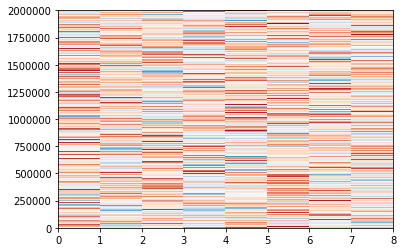

In [9]:
plt.pcolormesh(climate_gan_x[0], vmin=-30, vmax=30, cmap="RdBu_r")

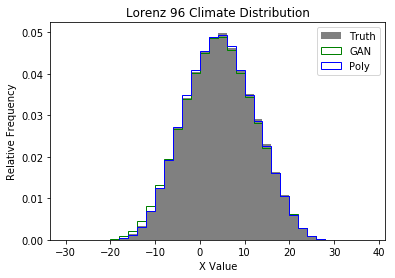

In [37]:
plt.figure(figsize=(6, 4))
c_bins = np.arange(-30, 40, 2)
plt.hist(x_vals.ravel(), bins=c_bins, color="gray", label="Truth", normed=True, cumulative=False)
plt.hist(climate_gan_x[0].ravel(), bins=c_bins, histtype="step", color="green", lw=1, label="GAN", normed=True, cumulative=False)
plt.hist(climate_poly_x[0].ravel(), bins=c_bins, histtype="step", color="blue", lw=1, label="Poly", normed=True, cumulative=False)
plt.ylabel("Relative Frequency")
plt.xlabel("X Value")
plt.title("Lorenz 96 Climate Distribution")
plt.legend()
plt.savefig("lorenz_climate_dist.png", dpi=250, bbox_inches="tight")

In [12]:
truth_hist, _ = np.histogram(x_vals.ravel(), bins=c_bins, normed=True)
gan_hist, _ = np.histogram(climate_gan_x[0].ravel(), bins=c_bins, normed=True)
poly_hist, _ = np.histogram(climate_poly_x[0].ravel(), bins=c_bins, normed=True)

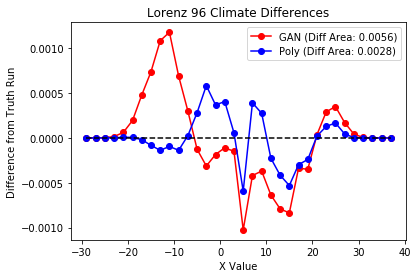

In [33]:
plt.figure(figsize=(6, 4))
bin_centers = (c_bins[1:] + c_bins[:-1]) / 2
gan_diff_area = np.sum(np.abs(gan_hist - truth_hist)) / 2
poly_diff_area = np.sum(np.abs(poly_hist - truth_hist)) / 2
plt.plot(bin_centers, gan_hist - truth_hist, 'ro-', label="GAN (Diff Area: {0:0.4f})".format(gan_diff_area))
plt.plot(bin_centers, poly_hist - truth_hist, 'bo-', label="Poly (Diff Area: {0:0.4f})".format(poly_diff_area))
plt.plot(bin_centers, np.zeros(bin_centers.shape), 'k--')
plt.legend()
plt.xlabel("X Value")
plt.ylabel("Difference from Truth Run")
plt.title("Lorenz 96 Climate Differences")
plt.savefig("lorenz_climate_dist_diff.png", dpi=250, bbox_inches="tight")

<Container object of 34 artists>

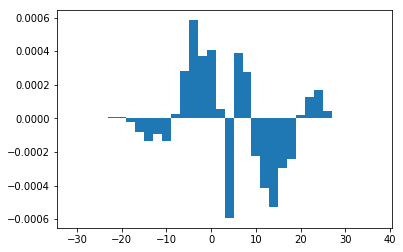

In [28]:
plt.bar(c_bins[:-1], poly_hist - truth_hist, 2)